In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.optim import Adam
import pandas as pd
import matplotlib.patches as patches

from GlaucomaDataset import GlaucomaDatasetBoundingBoxes, GlaucomaDataset
from unet import UNet, UNetWithAttention

In [2]:
origa_path = os.path.join("..", '..', "data", "ORIGA")
images_path = os.path.join(origa_path, "Images_Square")
masks_path = os.path.join(origa_path, "Masks_Square")

img_filenames = sorted(os.listdir(images_path))
mask_filenames = sorted(os.listdir(masks_path))

In [3]:
def update_image_path(path):
    split_path = path.split("/")
    return split_path[-1]

In [4]:
bb_df = pd.read_csv("../../data/ORIGA/bounding_boxes.csv")
bb_df['image_path'] = bb_df['image_path'].apply(update_image_path)
bb_df[['x1', 'y1', 'x2', 'y2']] //= 2

In [3]:
# Split into train, validation, and test sets (70, 15, 15)
train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(
    img_filenames, mask_filenames, test_size=0.3, random_state=42)

val_imgs, test_imgs, val_masks, test_masks = train_test_split(
    temp_imgs, temp_masks, test_size=0.5, random_state=42)

In [4]:
# Load data
batch_size = 8
n_workers = 4

train_set = GlaucomaDataset(images_path, masks_path, train_imgs, train_masks)
val_set = GlaucomaDataset(images_path, masks_path, val_imgs, val_masks)
test_set = GlaucomaDataset(images_path, masks_path, test_imgs, test_masks)

train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=n_workers, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=n_workers, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=n_workers, shuffle=True)

In [6]:
# Load data
batch_size = 8
n_workers = 4

train_set = GlaucomaDatasetBoundingBoxes(images_path, masks_path, train_imgs, train_masks, bb_df)
val_set = GlaucomaDatasetBoundingBoxes(images_path, masks_path, val_imgs, val_masks, bb_df)
test_set = GlaucomaDatasetBoundingBoxes(images_path, masks_path, test_imgs, test_masks, bb_df)

train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=n_workers, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=n_workers, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=n_workers, shuffle=True)

In [7]:
def display_image_with_bbox(img_array, bbox, color='red', linewidth=2):
    """
    Display an image with a bounding box overlay.
    
    Parameters:
    -----------
    img_array : numpy.ndarray
        Image as a numpy array.
    bbox : list or tuple
        Bounding box coordinates in the format [x1, y1, x2, y2]
        where (x1, y1) is the top-left corner and (x2, y2) is the bottom-right corner.
    color : str, default='red'
        Color of the bounding box.
    linewidth : int, default=2
        Width of the bounding box border.
    """
    # Create figure and axes
    fig, ax = plt.subplots(1)
    
    # Display the image
    ax.imshow(img_array)
    
    # Extract coordinates
    x1, y1, x2, y2 = bbox
    
    # Calculate width and height for the rectangle
    width = x2 - x1
    height = y2 - y1
    
    # Create a Rectangle patch
    rect = patches.Rectangle((x1, y1), width, height, linewidth=linewidth, 
                             edgecolor=color, facecolor='none')
    
    # Add the rectangle to the plot
    ax.add_patch(rect)
    
    # Remove axis ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Show the plot
    plt.tight_layout()
    plt.show()

## Define Metrics

In [5]:
def dice_coefficient(targets, preds, smooth=1e-6):
    # preds = (preds > 0.5).float 
    intersection = torch.sum(preds * targets, dim=(2,3))
    # want close to 1 (identical)
    dice = (2. * intersection + smooth) / (torch.sum(preds, dim=(2,3)) + torch.sum(targets, dim=(2,3)) + smooth)
    return dice.mean()

## Train and Test Loops

In [6]:
def trainloop(dataloader, model, loss_func, optimizer):
    num_batches = len(dataloader)
    train_loss, dice = 0., 0. 
    
    for image, image_name, mask, mask_name in dataloader:
        image, mask = image.to(device), mask.to(device)
        
        optimizer.zero_grad()
        pred = model(image)
        loss = loss_func(pred, mask)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        dice += dice_coefficient(pred, mask).item()
    train_loss /= num_batches
    dice /= num_batches
        
    return train_loss, dice

def testloop(dataloader, model, loss_func):
    num_batches = len(dataloader)
    test_loss, dice = 0. , 0.
    
    with torch.no_grad():
        for image, image_name, mask, mask_name in dataloader:
            image, mask = image.to(device), mask.to(device)
            print(image.shape)
            pred = model(image)
            test_loss += loss_func(pred, mask).item()
            dice += dice_coefficient(pred, mask).item()
    test_loss /= num_batches
    dice /= num_batches
    
    return test_loss, dice

## Initalize and Train Model

In [7]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetWithAttention(in_channels=3).to(device)

lr = 1e-4
loss_func = torch.nn.BCELoss(reduction='mean')
optimizer = Adam(model.parameters(), lr=lr)

In [8]:
# Training and validation
epochs = 10

best_val_dice = 0.0

for epoch in range(epochs):
    
    model.train()
    print(f"---Epoch {epoch+1}/{epochs}:---")
    train_loss, dice = trainloop(train_loader, model, loss_func, optimizer)
    print(f"Train Loss: {train_loss:.4f}   Train Dice: {dice:.4f}")
    
    model.eval()
    test_loss, dice = testloop(val_loader, model, loss_func)
    print(f"Test Error: \n Avg Loss: {test_loss:>8f}  Test Dice: {dice:.4f} \n")

    if dice > best_val_dice:
        torch.save(model.state_dict(), "prompted_unet_params.pth")

---Epoch 1/10:---
skip_connections[0]: torch.Size([8, 448, 64, 64]). x: torch.Size([8, 448, 32, 32])
x: torch.Size([8, 448, 64, 64]). g: torch.Size([8, 448, 64, 64])
skip_connections[1]: torch.Size([8, 224, 128, 128]). x: torch.Size([8, 448, 32, 32])
x: torch.Size([8, 224, 128, 128]). g: torch.Size([8, 448, 128, 128])


RuntimeError: Given groups=1, weight of size [112, 224, 1, 1], expected input[8, 448, 128, 128] to have 224 channels, but got 448 channels instead

In [12]:
import torchvision.transforms as transforms

In [13]:
clinic_img = np.array(Image.open("../../data/Clinic/Images/Subject (14).png").convert('RGB')) 
clinic_img = transforms.functional.to_tensor(clinic_img)
clinic_img = transforms.functional.resize(clinic_img, size=(256,256), interpolation=Image.BILINEAR)

In [14]:
xmin = 130
xmax = 175
ymin = 30
ymax = 83

In [15]:
bbox_mask = np.zeros([1, 256, 256])
bbox_mask[ymin:ymax, xmin:xmax] = 1
bbox_mask = torch.tensor(bbox_mask, dtype=torch.float32)

In [17]:
clinic_input_image = torch.cat([clinic_img, bbox_mask], dim=0)
clinic_input_image = clinic_input_image.to(device)

In [18]:
clinic_input_image.shape

torch.Size([4, 256, 256])

In [22]:
testloop(test_loader, model, loss_func)

torch.Size([8, 4, 256, 256])
torch.Size([8, 4, 256, 256])
torch.Size([8, 4, 256, 256])
torch.Size([8, 4, 256, 256])
torch.Size([8, 4, 256, 256])
torch.Size([8, 4, 256, 256])
torch.Size([8, 4, 256, 256])
torch.Size([8, 4, 256, 256])
torch.Size([8, 4, 256, 256])
torch.Size([8, 4, 256, 256])
torch.Size([8, 4, 256, 256])
torch.Size([8, 4, 256, 256])
torch.Size([2, 4, 256, 256])


(0.007393951921795423, 0.7880753599680387)

In [24]:
clinic_input_image.unsqueeze(0).shape

torch.Size([1, 4, 256, 256])

In [41]:
model = UNet(in_channels=4)
model.load_state_dict(torch.load("./prompted_unet_params.pth", weights_only=True))

<All keys matched successfully>

In [43]:
model.to(device)
with torch.no_grad():
    preds = model(clinic_input_image.unsqueeze(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


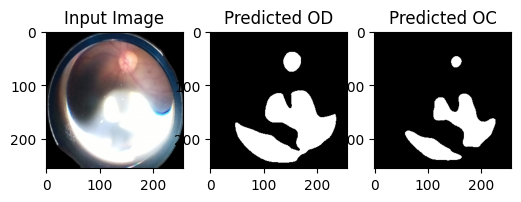

In [44]:
pred = preds.squeeze(0).cpu().numpy()
pred_od = pred[0]
pred_oc = pred[1]

pred_od = (pred_od > 0.5).astype(int)
pred_oc = (pred_oc > 0.5).astype(int)

if True:
    image = clinic_img.numpy().transpose(1,2,0)
    fig, ax = plt.subplots(1, 3, figsize=(6, 2))
    ax[0].imshow(image)
    ax[0].set_title("Input Image")
    ax[1].imshow(pred_od, cmap='gray')  # Optic Disc
    ax[1].set_title("Predicted OD")
    ax[2].imshow(pred_oc, cmap='gray')  # Optic Cup
    ax[2].set_title("Predicted OC")
    plt.show()